In [1]:
import jax
import jax.numpy as np
import numpy as onp

from scipy.stats import chi2

from jax.scipy.stats import bernoulli, norm
from jax import random, grad, jit, value_and_grad, vmap
from jax import tree_multimap, tree_map
from jax.flatten_util import ravel_pytree

from collections import namedtuple
from copy import deepcopy
from cycler import cycler

from functools import partial

from matplotlib import cm, rc
import matplotlib.pyplot as plt

from synthetic_data import toy_logistic_data

%matplotlib inline

In [ ]:
# Make sure to create this path
PATH = './figures'

In [81]:
# matplotlib Global Settings
rc('lines', lw=2)
rc('axes', lw=1.2, titlesize='large', labelsize='x-large')
rc('legend', fontsize='x-large')
rc('font', family='serif')

In [3]:
w, b, X, Y = toy_logistic_data(100, 82)

/home/ayman/miniconda3/envs/var-kl/lib/python3.8/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [4]:
data = (X, Y[:, 0])

In [5]:
def get_line_coords(w, b):
    w1, w2 = w
    x1s = np.linspace(-1, 1, 100)
    x2s = -(w1  * x1s + b) / (w2 + 1e-7)
    return x1s, x2s

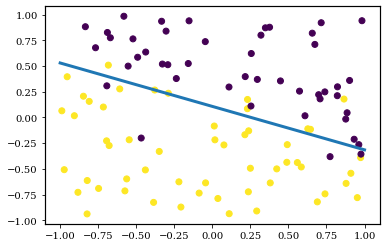

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=Y)
x1s, x2s = get_line_coords(w, b)
plt.plot(x1s, x2s)

In [7]:
LocScaleParameters = namedtuple('LocScaleParameters', ['loc', 'log_scale'])

In [8]:
def gaussian_sample(params, key, num_samples=1):
    mean = params.loc
    std_dev = np.exp(params.log_scale)
    samples = mean[np.newaxis, ...] + random.normal(key, shape=(num_samples, *mean.shape)) * std_dev
    return samples

In [9]:
def gaussian_log_pdf(params, x):
    assert x.shape == params.loc.shape, "Input must have the same shape as the event. Use vmap for batching."
    return np.sum(norm.logpdf(x, loc=params.loc, scale=np.exp(params.log_scale)))

def batch_log_pdf(params, x):
    log_pdf = vmap(gaussian_log_pdf, in_axes=(None, 0))(params, x)
    return log_pdf

In [10]:
LinearModel = namedtuple('LinearModel', ('w', 'b'))
Hyperparameters = namedtuple('Hyperparameters', ('likelihood_parameters', 'prior_parameters'))

In [11]:
def create_linear_model(features):
    w = LocScaleParameters(loc=np.zeros((features, )), log_scale=np.zeros((features, )))
    b = LocScaleParameters(loc=np.zeros(()), log_scale=np.zeros(()))
    return LinearModel(w=w, b=b)

def logistic_regression_prior(features):
    w = LocScaleParameters(loc=np.zeros((features, )), log_scale=np.zeros((features, )))
    b = LocScaleParameters(loc=np.zeros(()), log_scale=np.zeros(()))
    return LinearModel(w=w, b=b)

In [12]:
def model_map(fn, model):
    model_type = type(model)
    new_model = model_type(*map(fn, model))
    return new_model

In [13]:
def model_multimap(fn, model, extra_args):
    model_type = type(model)
    new_model = model_type(*map(fn, model, *extra_args))
    return new_model

In [14]:
logistic_regression_prior_params = logistic_regression_prior(2)
logistic_regression_posterior = create_linear_model(2)
hyperparameters = Hyperparameters(likelihood_parameters=None, prior_parameters=logistic_regression_prior_params)

In [15]:
def predict(samples, x):
    w = samples.w
    b = samples.b
    logits = np.dot(w, x) + b
    return jax.nn.sigmoid(logits)

In [16]:
def bernoulli_logpmf(k, p):
    tol = 1e-7
    p = np.clip(p, tol, 1 - tol)
    return k * np.log(p) + (1 - k) * np.log(1 - p)

In [17]:
def neg_likelihood(samples, data):
    x, y = data
    y_pred = vmap(predict, in_axes=(None, 0))(samples, x).T # SxB
    logprob = vmap(bernoulli_logpmf, in_axes=(None, 0))(y, y_pred)
    return -np.sum(logprob, axis=1)

In [18]:
def reparam_log_likelihood(samples, data):
    return - neg_likelihood(samples, data)

In [19]:
def vi_objective(variational_parameters, hyperparameters, data, key, num_samples=1):
    
    sampling_keys = random.split(key, num=2)
    
    samples = model_multimap(lambda x, y: gaussian_sample(x, y, num_samples=num_samples),
                             variational_parameters, (sampling_keys, ))
    
    exp_log_likelihood = reparam_log_likelihood(samples, data)
    
    prior_parameters = hyperparameters.prior_parameters
    
    exp_log_prior = model_multimap(batch_log_pdf, prior_parameters, (samples, ))
    exp_log_posterior = model_multimap(batch_log_pdf, variational_parameters, (samples, ))
    
    elbo_samples = (exp_log_likelihood - sum(exp_log_posterior) + sum(exp_log_prior))
    
    return - np.mean(elbo_samples)

In [20]:
vi_loss_closure = jit(partial(vi_objective, hyperparameters=hyperparameters, data=data, num_samples=5))
vi_loss_value_and_grad = jit(value_and_grad(vi_objective), static_argnums=(1, 2, 4))

In [21]:
def varKL_objective(variational_parameters, hyperparameters, data, key, num_samples=1):
    
    sampling_keys = random.split(key, num=2)
    
    samples = model_multimap(lambda x, y: jax.lax.stop_gradient(gaussian_sample(x, y, num_samples=num_samples)),
                             variational_parameters, (sampling_keys, ))
    
    exp_log_likelihood = reparam_log_likelihood(samples, data)
    
    prior_parameters = hyperparameters.prior_parameters
    
    exp_log_prior = model_multimap(batch_log_pdf, prior_parameters, (samples, ))
    exp_log_posterior = model_multimap(batch_log_pdf, variational_parameters, (samples, ))
    
    elbo_samples = (exp_log_likelihood - sum(exp_log_posterior) + sum(exp_log_prior))
    
    return 0.5 * np.var(elbo_samples, ddof=1)

In [22]:
varKL_loss_value_and_grad = jit(value_and_grad(varKL_objective), static_argnums=(1, 2, 4))

In [23]:
def bbvi_objective(variational_parameters, hyperparameters, data, key, num_samples=1):
    
    sampling_keys = random.split(key, num=2)
    
    samples = model_multimap(lambda x, y: gaussian_sample(x, y, num_samples=num_samples),
                             variational_parameters, (sampling_keys, ))
    
    samples = jax.lax.stop_gradient(samples)
    
    exp_log_likelihood = reparam_log_likelihood(samples, data)
    
    prior_parameters = hyperparameters.prior_parameters
    
    exp_log_prior = model_multimap(batch_log_pdf, prior_parameters, (samples, ))
    exp_log_posterior = model_multimap(batch_log_pdf, variational_parameters, (samples, ))
    
    elbo_samples = (exp_log_likelihood - sum(exp_log_posterior) + sum(exp_log_prior))
    loss_samples = jax.lax.stop_gradient(elbo_samples) * sum(exp_log_posterior)
    return - np.mean(loss_samples)

In [24]:
bbvi_loss_value_and_grad = jit(value_and_grad(bbvi_objective), static_argnums=(1, 2, 4))

In [25]:
def log_posterior(variational_parameters, data, key, num_samples=1):
    sampling_keys = random.split(key, num=2)
    
    samples = model_multimap(lambda x, y: gaussian_sample(x, y, num_samples=num_samples),
                             variational_parameters, (sampling_keys, ))
    
    samples = jax.lax.stop_gradient(samples)
    
    exp_log_posterior = model_multimap(batch_log_pdf, variational_parameters, (samples, ))
    return - np.mean(sum(exp_log_posterior))

In [26]:
score_function = jit(grad(log_posterior), static_argnums=(1, 3))

In [27]:
def gd_update(param, grad, learning_rate):
    return param - learning_rate * grad

In [28]:
learning_rate = 0.001
key = random.PRNGKey(42)
param_periods = [deepcopy(logistic_regression_posterior)]
for i in range(100):
    _, key = random.split(key)
#     loss, gradients = vi_loss_value_and_grad(logistic_regression_posterior, hyperparameters, data, key, 5)
    loss, gradients = varKL_loss_value_and_grad(logistic_regression_posterior, hyperparameters, data, key, 5)
    update_fn = partial(gd_update, learning_rate=learning_rate)
    updates = tree_multimap(update_fn, logistic_regression_posterior, (gradients))
    logistic_regression_posterior = LinearModel(*updates)
    param_periods.append(deepcopy(logistic_regression_posterior))
    
    print("Loss =", loss)

Loss = 240.2094
Loss = 680.01416
Loss = 41.34618
Loss = 489.4043
Loss = 434.07977
Loss = 221.19269
Loss = 100.685234
Loss = 540.5913
Loss = 260.21265
Loss = 315.636
Loss = 284.7276
Loss = 107.78433
Loss = 88.08228
Loss = 135.55719
Loss = 102.032715
Loss = 76.88719
Loss = 42.501156
Loss = 643.276
Loss = 358.69846
Loss = 219.87675
Loss = 45.359734
Loss = 84.21425
Loss = 64.522934
Loss = 179.36732
Loss = 58.478485
Loss = 200.66293
Loss = 11.385413
Loss = 150.36328
Loss = 225.26653
Loss = 240.12921
Loss = 150.92317
Loss = 62.139114
Loss = 41.902008
Loss = 28.421036
Loss = 176.81197
Loss = 171.09479
Loss = 104.56733
Loss = 78.47492
Loss = 53.664696
Loss = 186.33241
Loss = 4.6439724
Loss = 150.39024
Loss = 434.19424
Loss = 60.653103
Loss = 371.00934
Loss = 81.270325
Loss = 140.48479
Loss = 62.92932
Loss = 44.874866
Loss = 48.117764
Loss = 15.176222
Loss = 90.3143
Loss = 64.90752
Loss = 70.30269
Loss = 210.32304
Loss = 73.2924
Loss = 11.024809
Loss = 37.370342
Loss = 83.77139
Loss = 19.620567

In [29]:
key = random.PRNGKey(42)

def sample_grads(params, key, num_samples):
    varKL_loss_grads = []
    bbvi_loss_grads = []
    cv_bbvi = []
    single_sample_grads = []
    single_sample_cv = []
    single_sample_value = []
    for i in range(1000):
        key, _ = random.split(key)
        # VARIANCE LOSS
        _, g = varKL_loss_value_and_grad(params, hyperparameters, data, key, num_samples)
        g, _ = ravel_pytree(g)
        varKL_loss_grads.append(g)
        ## BBVI LOSS
        _, g = bbvi_loss_value_and_grad(params, hyperparameters, data, key, num_samples)
        g, _ = ravel_pytree(g)
        bbvi_loss_grads.append(g)
        ## CV BBVI LOSS
        cv = score_function(params, data, key, num_samples)
        cv, _ = ravel_pytree(cv)
        cv_bbvi.append(cv)
        
        
        key, _ = random.split(key)
        ## Single sample grad
        _, g= bbvi_loss_value_and_grad(params, hyperparameters, data, key, 1)
        g, _ = ravel_pytree(g)
        single_sample_grads.append(g)
        ## Single samples CV
        cv = score_function(params, data, key, 1)
        cv, _ = ravel_pytree(cv)
        single_sample_cv.append(cv)
        ## Single sample value
        v, _ = vi_loss_value_and_grad(params, hyperparameters, data, key, 1)
        single_sample_value.append(v)
        

    varKL_loss_grads = np.stack(varKL_loss_grads)
    bbvi_loss_grads = np.stack(bbvi_loss_grads)
    cv_bbvi = np.stack(cv_bbvi)
    single_sample_grads = np.stack(single_sample_grads)
    single_sample_cv = np.stack(single_sample_cv)
    single_sample_value = np.stack(single_sample_value)
    return varKL_loss_grads, bbvi_loss_grads, cv_bbvi, single_sample_grads, single_sample_cv, single_sample_value

In [30]:
def compute_cv_coeff(control_variates, gradients):
    coeff = []
    for i in range(gradients.shape[1]):
        cov = onp.cov(control_variates[:, i], gradients[:, i], rowvar=False)
        coeff.append(cov[0, 1] / cov[0, 0])
    return np.stack(coeff)

In [31]:
def compute_delta(control_variates, function_values):
    coeff = []
    for i in range(control_variates.shape[1]):
        cov = onp.cov(control_variates[:, i] ** 2, function_values, rowvar=False)
        var = np.var(control_variates[:, i])
        coeff.append(cov[0, 1] / var)
    return np.stack(coeff)

In [32]:
def compute_chi2_confidence(x, df):
    chi_2_interval = chi2.ppf([0.01, 0.99], df=df)
    return df * x[None, :] / chi_2_interval[:, None]

In [33]:
CV_NUM_SAMPLES = [2, 1000]

In [34]:
def run(params, key):
    results_dict = {
        'bbvi': [],
        'optimal_cv_bbvi': [],
        'variance_loss': [],
    }
    for params in param_periods:
        samples = sample_grads(params, key, 4)
        varKL_loss_grads, bbvi_loss_grads, cv_bbvi, single_sample_grads, single_samples_cv, single_sample_value = samples

        perm = onp.random.permutation(len(cv_bbvi))
        
        cv_variance = []
        for cv_num_samples in CV_NUM_SAMPLES:
            optimal_cv_bbvi_coeff = compute_cv_coeff(single_samples_cv[perm[:cv_num_samples]], single_sample_grads[perm[:cv_num_samples]])
            optimal_cv_bbvi_loss_grads = bbvi_loss_grads - optimal_cv_bbvi_coeff[None, :] * cv_bbvi
            cv_variance.append(np.var(optimal_cv_bbvi_loss_grads, axis=0, ddof=1))
        
        results_dict['variance_loss'].append(np.var(varKL_loss_grads, axis=0, ddof=1))
        results_dict['bbvi'].append(np.var(bbvi_loss_grads, axis=0, ddof=1))
        results_dict['optimal_cv_bbvi'].append(cv_variance)
    
    return results_dict

In [35]:
results_dict = run(logistic_regression_posterior, key)

1.4440859440512543
0.7516177407072249
0.040713832040893294
12.451666914219459
2.0733256078387274
5.685781438996829
0.9420545918549228
0.9357311292445075
1.8878450391367514
1.7928663331228707
1.0080287876336866
2.2401958590149382
0.6083423075837555
0.31814512950655544
0.8541598441447196
0.19456519653729787
5.182041138668929
0.22926461573706547
0.9408642977489091
0.9206110287088879
1.8878443323017804
1.7928666831020172
1.010969088938791
2.240195757795857
0.31079512332783565
0.5165104387095991
0.0010100694478580863
0.1419538726502072
0.7170422284689266
1.988224129304344
0.9411598096872825
0.9972332752442186
1.88784528704437
1.7928663136898406
1.0165562641841928
2.240196131408922
0.24193501244766047
0.6893690037679367
0.08692961062095605
0.04636498428727265
3.3614993108718654
17.09467094406496
0.9256347908845065
0.9739613121406344
1.8878452268003425
1.792866158847212
1.0054172912893369
2.2401964166572013
0.09383269581491227
1.165620968410666
0.23209489911688314
0.8082616858620213
0.1681770

2.3683832699237257
0.9911862515654679
0.4491804796828536
0.37313542335448024
1.4032245807436823
1.3616511503315554
1.228114006038996
1.2068822930537537
1.8878446924445653
1.7928658967514521
2.446467209321251
2.240195634072431
0.9798577789411027
0.9176453273226333
0.7549202455822811
0.02182287458390597
1.2988166855935095
0.05783144753839231
1.2289893512279864
1.22327997152563
1.8878448409299176
1.792866086592704
2.460948015576699
2.240196369761202
3.5958920095055262
2.006478779601821
0.18973718175981483
2.1909762446696295
0.146166878607346
0.1766688043715148
1.2309710367619815
1.2501255109524085
1.8878453501218444
1.7928661569799504
2.459793659175662
2.2401959750829867
0.35136589145374053
1.1958711728738098
0.03564609668183216
1.0735906398929846
5.139430306714647
4.839395076306118
1.2350129392883078
1.2664000151075314
1.8878450987964033
1.7928658145584873
2.4896651232805764
2.24019629281943
1.1463545065354204
1.2549475903193605
1.7206930954041884
1.3473502533854305
0.9912846938155155
1.

0.1215847325559043
1.7047044312282655
0.04558392501015085
2.193696599027975
0.816500469816674
0.20592559095494112
1.684096957017265
1.6573002382609276
1.88784504107581
1.7928669662646564
6.234840051125774
2.240195575883972
4.524364101370402
0.8982222284597486
7.943193548724594
0.3237932063505867
5.494849009150158
4.346771226873402
1.6926031014669904
1.6129196020581908
1.8878452467532938
1.7928656634931717
6.188411653069376
2.2401963762137744
0.04656367312745324
0.09986608936374541
0.034279293148076206
0.001590587635449836
1.4652749952754625
0.13644362075744754
1.6744202474019647
1.6151786182048964
1.8878447431997372
1.7928657577458509
6.135771942957058
2.2401962104314084
0.061911869492250915
2.640238887574235
0.09938645398730417
7.921995270455485
0.13735430956432992
0.09201974787400868
1.7268543511721486
1.6257970094943512
1.8878456324287531
1.7928664314332134
6.154022085892218
2.240195713545782
10.604813249076983
0.003459665293876313
39.833390522387624
0.0025761218873938674
19.7575590

In [60]:
import pickle
with open('./results/logistic_regression_variance_trace.pk', 'wb') as f:
    pickle.dump(results_dict, f)

# with open('./results/logistic_regression_variance_trace.pk', 'rb') as f:
#     results_dict = pickle.load(f)

In [37]:
def get_title(idx):
    if idx % 2 == 0:
        return f'mean'
    else:
        return 'log standard deviation'

In [111]:
def plot_trace(results_dict, param_idx, log_scale=True):
    bbvi_colours = ['C7', 'C0', 'C5', 'C6', 'C7', 'C8', 'C9']
    def plot_single_trace(results, name, c, ls='-'):
        stacked = results[:, param_idx]
        xx = np.arange(0, stacked.shape[0], step=1)
        plt.plot(xx, stacked, label=name, c=c, ls=ls, alpha=0.8)
        bounds = compute_chi2_confidence(stacked, df=999)
        plt.fill_between(xx, bounds[0, :], bounds[1, :], alpha=0.2, color=c)
        
    plt.figure(figsize=(5, 3))
    plot_single_trace(np.stack(results_dict['bbvi']), name='Reinforce', c='C1')
    names = ['Sampled estimator', 'Oracle estimator']
    for i, s in enumerate(CV_NUM_SAMPLES):
        plot_single_trace(np.array(results_dict['optimal_cv_bbvi'])[:, i, :], 
                          name=names[i], c=bbvi_colours[i])
    
    plot_single_trace(np.stack(results_dict['variance_loss']), name='VarGrad', c='C3')
#     plt.xticks(np.arange(len(NUM_SAMPLES)), NUM_SAMPLES)

    plt.xlabel('epoch')
    plt.ylabel('Variance')
    if log_scale:
        plt.yscale('log')
#     plt.title(f'Logistic regression gradient variance w.r.t. variational {get_title(param_idx)}', fontsize='x-large')
    plt.grid(axis='y', alpha=0.2)
#     plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.8), ncol=2, fontsize='large', frameon=False)
    plt.legend(loc='upper left', ncol=1, fontsize='medium', frameon=False)
    plt.savefig(f'{PATH}/variance_wrt_iterations_{param_idx}.pdf', bbox_inches='tight')

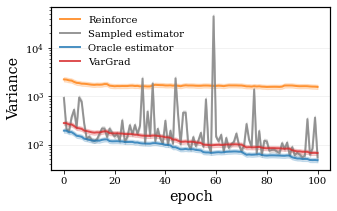

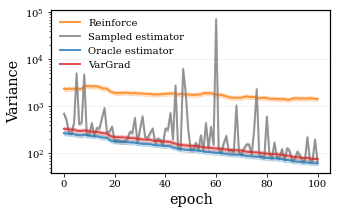

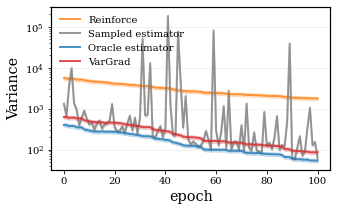

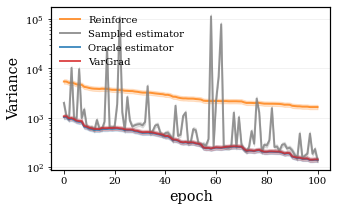

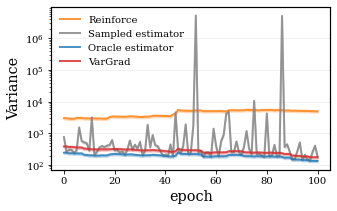

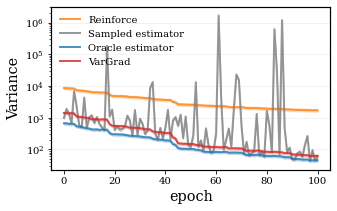

In [112]:
for i in range(6):
    plot_trace(results_dict, i)